# ベースライン作成

---

## 4.3 ファイルの読み込み

### インポート

In [65]:
# 基本的な数値計算・配列操作ライブラリ
import numpy as np

# データフレーム操作ライブラリ
import pandas as pd 

# ファイル・ディレクトリ操作
import os

# オブジェクトの保存・読み込み
import pickle

# メモリ管理・解放
import gc 

# データの分布・統計情報の可視化
import ydata_profiling as pdp

# グラフ描画ライブラリ
import matplotlib.pyplot as plt

import matplotlib_fontja

# 前処理用ライブラリ
from sklearn.preprocessing import StandardScaler  # 標準化
from sklearn.preprocessing import MinMaxScaler   # 最小最大スケーリング 
from sklearn.preprocessing import LabelEncoder   # ラベルエンコーディング
from sklearn.preprocessing import OneHotEncoder  # ワンホットエンコーディング

# データ分割用ライブラリ
from sklearn.model_selection import train_test_split    # 学習/テストデータ分割
from sklearn.model_selection import KFold              # 交差検証
from sklearn.model_selection import StratifiedKFold    # 層化抽出による交差検証

# モデル評価指標
from sklearn.metrics import accuracy_score      # 正解率
from sklearn.metrics import roc_auc_score      # ROC-AUC
from sklearn.metrics import confusion_matrix   # 混同行列

# 勾配ブースティング実装ライブラリ
import lightgbm as lgb

# 警告メッセージの非表示化
import warnings
warnings.filterwarnings("ignore")


### ファイルの読み込み
- Excelファイル
```python
df = pd.read_excel("sample.xlsx")
```

- タブ区切りファイル
```python 
df = pd.read_csv("sample.tsv", sep="\t")
```
- Shift JIS形式のcsvファイル
```python
df = pd.read_csv("sample.csv", encoding="shift_jis")
```
```

In [66]:
df_train = pd.read_csv("../../input/titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

## 4.4 データの確認

### レコード数 / カラム数 の確認

In [67]:
print(df_train.shape)
print("レコード数:", len(df_train))
print("カラム数:", len(df_train.columns))

(891, 12)
レコード数: 891
カラム数: 12


### データの確認

In [68]:
df_train.info() # 自動判別のため、修正の確認必須

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### データ型の変換

In [69]:
df_train["Pclass"] = df_train["Pclass"].astype(object)
df_train[["Pclass"]].info()

df_train["Pclass"] = df_train["Pclass"].astype(np.int64)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


### 欠損値の確認

In [70]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

---

## 4.5 データセットの作成

### 目的変数と説明変数を作成

- 数値データである
- 欠損値がない
- 金掛けてるほうが生き残りそう

In [71]:
# 説明変数 -> [Pclass,Fare]   /   目的変数 -> [Survived]   /   乗客の識別子 -> [PassengerId]
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], df_train[["Survived"]], df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


---

## 4.6 バリデーション設計

### ホールドアウト検証

In [72]:
# 訓練データをさらに訓練用(tr)と検証用(va)に分割する
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,      # 元の説明変数
    y_train,      # 元の目的変数
    test_size=0.2,    # 検証用データの割合を20%に設定
    shuffle=True,     # データをランダムに並び替える
    stratify=y_train, # 目的変数の比率が同じになるように分割
    random_state=123  # 乱数シードを固定して再現性を確保
)

# 分割後のデータサイズを確認
print(x_tr.shape, y_tr.shape)    # 訓練用データのサイズ
print(x_va.shape, y_va.shape)    # 検証用データのサイズ

# 目的変数(Survived)の平均値を比較して、
# データの分布が元のデータと同じように保たれているか確認
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),  # 元の訓練データ全体での生存率
    y_tr["Survived"].mean(),     # 分割後の訓練用データでの生存率
    y_va["Survived"].mean(),     # 分割後の検証用データでの生存率
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


### クロスバリデーション

In [73]:
# 交差検証の分割数を5に設定
n_splits = 5

# StratifiedKFoldでデータを5分割する
# shuffle=Trueでデータをランダムに並び替え、random_stateで乱数を固定
cv = list(StratifiedKFold(n_splits=n_splits, 
                         shuffle=True, 
                         random_state=123).split(x_train, y_train))

# 各分割でのデータの確認
for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)  # 分割番号の表示
    
    # cv[nfold][0]には訓練用インデックス、cv[nfold][1]には検証用インデックスが格納されている
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    
    # インデックスを使って、訓練データと検証データを取り出す
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]  # 訓練用データ
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]  # 検証用データ
    
    # 各分割でのデータサイズを確認
    print(x_tr.shape, y_tr.shape)    # 訓練用データのサイズ
    print(x_va.shape, y_va.shape)    # 検証用データのサイズ
    
    # 目的変数の平均値を比較して、データの分布が保たれているか確認
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Survived"].mean(),  # 元の訓練データ全体での生存率
        y_tr["Survived"].mean(),     # 分割後の訓練用データでの生存率
        y_va["Survived"].mean(),     # 分割後の検証用データでの生存率
    ))

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388


---

## 4.7 モデル学習 ( 勾配ブースティング )

### ホールドアウト検証の場合

#### データセットの作成

In [74]:
# トレーニングデータを訓練用とバリデーション用に分割
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,    # 20%をバリデーション用に使用
                                          shuffle=True,     
                                          stratify=y_train, # 目的変数の分布が元データと同じになるように分割
                                          random_state=123)

# データの形状を確認
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)

# 目的変数（Survived）の平均値を確認
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


#### モデル学習

In [75]:
# LightGBMモデルのハイパーパラメータを設定
params = {
    'boosting_type': 'gbdt',      # 勾配ブースティングの種類
    'objective': 'binary',        # 二値分類問題
    'metric': 'auc',             # 評価指標としてAUCを使用
    'learning_rate': 0.1,        # 学習率
    'num_leaves': 16,            # 木の葉の最大数
    'n_estimators': 100000,      # 最大イテレーション数
    "random_state": 123,         # 乱数シード
    "importance_type": "gain",   # 特徴量重要度の計算方法
}

# モデルのインスタンスを作成
model = lgb.LGBMClassifier(**params)

# モデルの学習
# eval_set: 訓練中に評価するデータセット
# callbacks: early_stoppingで過学習を防ぎ、log_evaluationで学習経過を表示
model.fit(x_tr,y_tr,
         eval_set=[(x_tr,y_tr), (x_va,y_va)],
         callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
                   lgb.log_evaluation(10),],)  

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.792256	valid_1's auc: 0.744862
[20]	training's auc: 0.801914	valid_1's auc: 0.752372
[30]	training's auc: 0.808339	valid_1's auc: 0.759223
[40]	training's auc: 0.816595	valid_1's auc: 0.759223
[50]	training's auc: 0.820771	valid_1's auc: 0.755138
[60]	training's auc: 0.82582	valid_1's auc: 0.754809
[70]	training's auc: 0.82995	valid_1's auc: 0.753755
[80]	training's auc: 0.832645	valid_1's auc: 0.752767
[90]	training's auc: 0.834593	valid_1's auc: 0.750132
[100]	training's auc: 0.837247	valid_1's auc: 0.747892
[110]	training's auc: 0.839036	valid_1's auc: 0.746838
[120]	training's auc: 0.840764	valid_1's auc: 0.746311
[130]	training's auc: 0.842007	valid_1's auc: 0.746706
Early stopping, best iteration is:
[35]	training's auc: 0.81342	valid_1's auc: 0.761265


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

#### 精度の評価

In [76]:
# 予測確率を計算（陽性クラスの確率のみを取得）
y_tr_pred = model.predict_proba(x_tr)[:,1] # type: ignore
y_va_pred = model.predict_proba(x_va)[:,1] # type: ignore

# 予測精度（正解率）を計算
# 確率が0.5以上なら1、未満なら0に変換して正解率を計算
metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5, 1, 0))
metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5, 1, 0))

# 訓練データとバリデーションデータの正解率を表示
print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))

[accuracy] tr: 0.75, va: 0.73


#### 説明変数の重要度の算出

In [77]:
# 特徴量の重要度をデータフレームとして作成し、重要度順にソート
imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_})
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp
0,Fare,903.440373
1,Pclass,229.457186


### クロスバリデーションの場合

#### データセットの作成

In [78]:
# トレーニングデータを訓練用とバリデーション用に分割
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,    # 20%をバリデーション用に使用
                                          shuffle=True,     
                                          stratify=y_train, # 目的変数の分布が元データと同じになるように分割
                                          random_state=123)

# データの形状を確認
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)

# 目的変数（Survived）の平均値を確認
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


#### モデルの学習と精度の評価

In [79]:
# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

# 交差検証の準備
metrics = []
imp = pd.DataFrame()
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

# 交差検証によるモデル学習
for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    
    # データの分割
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    
    # データの形状と分布の確認
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Survived"].mean(),
        y_tr["Survived"].mean(),
        y_va["Survived"].mean(),
    ))
    
    # モデルの学習
    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr,y_tr), (x_va,y_va)],
              callbacks=[
                  lgb.early_stopping(stopping_rounds=100, verbose=True),
                  lgb.log_evaluation(100),
              ],
             )

    
    # 予測と精度の評価
    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))    
    
    # 評価結果の保存
    metrics.append([nfold, metric_tr, metric_va])
    
    # 特徴量重要度の保存
    tmp_imp = pd.DataFrame({
        "col": x_train.columns, 
        "imp": model.feature_importances_, 
        "nfold": nfold
    })
    imp = pd.concat([imp, tmp_imp], axis=0, ignore_index=True)

# 最終結果の表示
print("-"*20, "result", "-"*20)
metrics = np.array(metrics)
print(metrics)
print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),
))

imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False)
print("Done.")

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
Early stopping, best iteration is:
[12]	training's auc: 0.793779	valid_1's auc: 0.740382
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.826717	valid_1's auc: 0.753008
Early stopping, best iteration is:
[26]	training's auc: 0.807006	valid_1's auc: 0.757219
[accuracy] tr: 0.75, va: 0.68
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.839483	valid_1's auc: 0.732687
[200]	training's auc: 0.849542	valid_1's auc: 0.737233
Ea

#### 説明変数の重要度の算出

In [80]:
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,679.390270,356.992896
1,Pclass,291.704529,138.843896


### ベースラインの評価 (ホールドアウト)

#### ベースライン検証用のデータ作成

In [81]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                            y_train,
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=y_train,
                                            random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 2) (712, 1)
(179, 2) (179, 1)


#### 学習データと検証データの作成

In [82]:
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 2) (569, 1)
(143, 2) (143, 1)


#### モデル学習

In [83]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1),(x_va1,y_va1)],
          callbacks=[
              lgb.early_stopping(stopping_rounds=100, verbose=True),
              lgb.log_evaluation(10),
              ],
          )

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.792153	valid_1's auc: 0.72562
[20]	training's auc: 0.810025	valid_1's auc: 0.712087
[30]	training's auc: 0.822545	valid_1's auc: 0.72376
[40]	training's auc: 0.829204	valid_1's auc: 0.719421
[50]	training's auc: 0.836699	valid_1's auc: 0.720455
[60]	training's auc: 0.841808	valid_1's auc: 0.716322
[70]	training's auc: 0.84684	valid_1's auc: 0.71281
[80]	training's auc: 0.851009	valid_1's auc: 0.716529
[90]	training's auc: 0.85472	valid_1's auc: 0.720041
[100]	training's auc: 0.856354	valid_1's auc: 0.722934
Early stopping, best iteration is:
[7]	training's auc: 0.787396	valid_1's auc: 0.729545


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

#### 検証データとベースライン検証用データの予測値算出

In [84]:
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

#### モデル精度の比較

In [85]:
print("[検証データ] acc: {:.4f}".format(accuracy_score(y_va1, y_va1_pred)))
print("[ベースライン検証用データ] acc: {:.4f}".format(accuracy_score(y_va2, y_va2_pred)))

[検証データ] acc: 0.7133
[ベースライン検証用データ] acc: 0.7095


#### 誤差分布の比較

In [86]:
print("検証データ")
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize="all"))
print("ベースライン検証用データ")
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize="all"))

検証データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
ベースライン検証用データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


<img src="../images/20241220_014744.png" width="500" height="250"> <br>

#### 予測値の分布比較

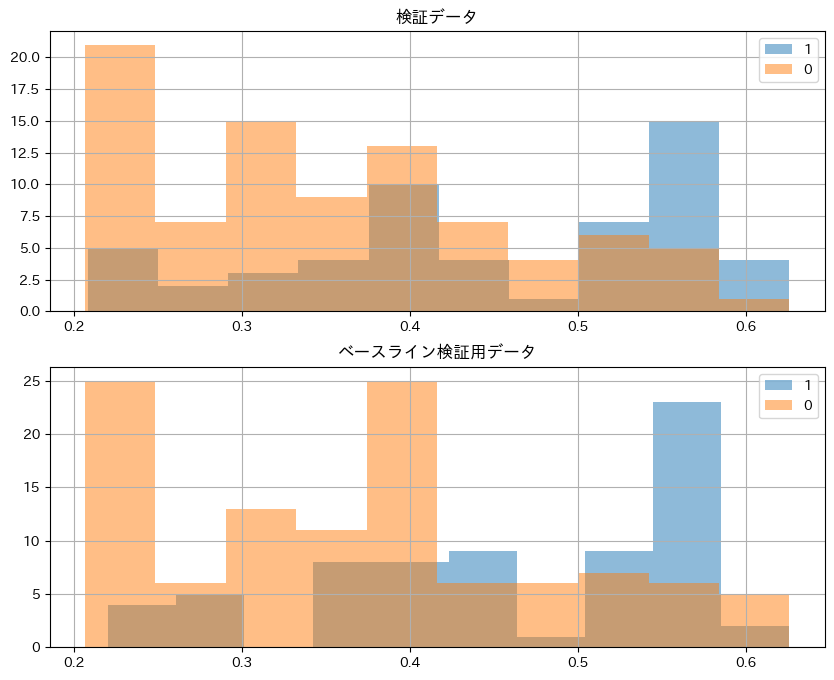

In [87]:
# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1] # type: ignore
y_va2_pred_prob = model.predict_proba(x_va2)[:,1] # type: ignore

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))
# 検証データ
fig.add_subplot(2,1,1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証用データ
fig.add_subplot(2,1,2)
plt.title("ベースライン検証用データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

---

## 4.8 モデル推論

### 推論データセットの作成

In [88]:
df_test = pd.read_csv("../../input/titanic/test.csv")
x_test = df_test[["Pclass", "Fare"]]
id_test = df_test[["PassengerId"]]

### 学習モデルで推論

In [89]:
y_test_pred = model.predict(x_test)

### 提出用ファイルの作成

In [90]:
df_submit = pd.DataFrame({"PassengerId":id_test["PassengerId"], "Survived":y_test_pred})
display(df_submit.head(5))
df_submit.to_csv("submission_baseline.csv", index=None) # type: ignore

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
